# Assignment 3

## Abstract

This study presents a comprehensive evaluation of model interpretability across three distinct types of machine learning models: a linear model, a tree-based model, and a model derived from an automated machine learning (AutoML) framework. Initially, a linear regression model is fitted, and its coefficients are meticulously interpreted to understand the influence of each predictor on the response variable. Subsequently, a tree-based model is constructed, with a detailed interpretation of the decision nodes providing insights into the model's splitting criteria and data partitioning strategies. Furthermore, an AutoML procedure is employed to systematically search for an optimal model, considering a diverse set of algorithms and hyperparameters. Post model development, a SHAP (SHapley Additive exPlanations) analysis is conducted on all models to compute and interpret the SHAP values, which quantify the contribution of each feature to the prediction of individual samples. The SHAP analysis facilitates a comparison with traditional interpretability methods associated with each model type. The results highlight the trade-offs between model complexity and interpretability, providing a nuanced understanding of feature importance across linear, tree-based, and AutoML-generated models. This investigation not only underscores the effectiveness of SHAP in elucidating model predictions but also offers valuable perspectives on integrating interpretability into the model selection process within AutoML pipelines. The findings are expected to guide practitioners in choosing appropriate modeling techniques that balance predictive performance with interpretability, catering to domain-specific requirements.

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [2]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [3]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [4]:
min_mem_size=6 
run_time=222

In [5]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

4


In [6]:
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:43042..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.10+11-LTS-240, mixed mode, sharing)
  Starting server from C:\Users\pende\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\pende\AppData\Local\Temp\tmpx63meaiy
  JVM stdout: C:\Users\pende\AppData\Local\Temp\tmpx63meaiy\h2o_pende_started_from_python.out
  JVM stderr: C:\Users\pende\AppData\Local\Temp\tmpx63meaiy\h2o_pende_started_from_python.err
  Server is running at http://127.0.0.1:43042
Connecting to H2O server at http://127.0.0.1:43042 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 25 days
H2O_cluster_name:,H2O_from_python_pende_e6ziud
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [7]:
#importing the dataset to this notebook
data = pd.read_csv("https://raw.githubusercontent.com/MukulSaiPendem/DSEM_Assignment_2/main/val_stats.csv", low_memory=False)

## DATASET DESCRIPTION
This dataset contains data related to player performance in a competitive video game Valorant. This is a first person shooter video game. 

In [8]:
data.columns

Index(['region', 'name', 'tag', 'rating', 'damage_round', 'headshots',
       'headshot_percent', 'aces', 'clutches', 'flawless', 'first_bloods',
       'kills', 'deaths', 'assists', 'kd_ratio', 'kills_round', 'most_kills',
       'score_round', 'wins', 'win_percent', 'agent_1', 'agent_2', 'agent_3',
       'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills',
       'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills',
       'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills'],
      dtype='object')

## Variable Descriptions

**Region**: 
<span style="color:green;">Indicates the geographical location or server region of the player. Different regions can represent different player communities and competitive environments.</span>

**Name**: 
<span style="color:green;">The in-game username chosen by the player. It's a unique identifier for each player within the game.</span>

**Tag**: 
<span style="color:green;">An additional identifier or code associated with the player's account, often used in conjunction with the name for unique identification.</span>

**Rating**: 
<span style="color:green;">A numerical value representing the player's skill level or rank. Higher ratings usually indicate more skilled or experienced players.</span>

**Damage per Round**: 
<span style="color:green;">Shows the average amount of damage the player inflicts on opponents in each round. This is a measure of the player's effectiveness in harming opponents, with higher values indicating greater impact in the game.</span>

**Headshots**: 
<span style="color:green;">The total number of times a player has successfully hit opponents in the head. Headshots are typically more difficult to achieve but are more effective in the game.</span>

**Headshot Percent**: 
<span style="color:green;">The percentage of the player's shots that result in headshots. A higher percentage is indicative of better precision and aiming skill.</span>

**Kills**: 
<span style="color:green;">The total number of opponents a player has eliminated. This is a direct measure of offensive performance.</span>

**Deaths**: 
<span style="color:green;">The number of times a player has been eliminated by an opponent. This figure is used to assess a player's survivability and defensive skills.</span>

**Assists**: 
<span style="color:green;">The count of assists represents the number of times a player has helped a teammate kill an opponent. Assists can indicate a player's teamwork and support capabilities.</span>

**K/D Ratio**: 
<span style="color:green;">The kill/death ratio is calculated by dividing the number of kills by the number of deaths. A higher ratio suggests that a player eliminates more opponents than they are eliminated.</span>

**Kills per Round**: 
<span style="color:green;">The average number of kills a player achieves each round, which shows their consistent contribution to the team's offensive efforts.</span>

**Most Kills**: 
<span style="color:green;">The highest number of kills a player has achieved in a single game. This can highlight a player's peak performance capability.</span>

**Score per Round**: 
<span style="color:green;">The average score a player achieves per round, factoring in various aspects of their performance, not just eliminations.</span>

**Wins**: 
<span style="color:green;">The number of games a player or their team has won. Wins are the ultimate objective and indicate the effectiveness of a player's contribution to the team's success.</span>

**Win Percent**: 
<span style="color:green;">The percentage of games won out of all games played. This metric is used to gauge overall team success and, indirectly, the player's impact on games.</span>

**Aces**: 
<span style="color:green;">Counts the number of times a player has single-handedly eliminated all opposing team members in a round. This is a rare and notable achievement, showcasing exceptional individual skill.</span>

**Clutches**: 
<span style="color:green;">The number of rounds a player wins single-handedly while being the last surviving member of their team against multiple opponents. This metric highlights the player's ability to perform under high-pressure situations.</span>

**Flawless**: 
<span style="color:green;">Refers to rounds where the player's team wins without losing any team members. It indicates a round dominated by the player's team.</span>

**Gun Statistics**: 
<span style="color:green;">These include detailed performance metrics for different guns used by players. Each gun has associated statistics like gun name, head, body, legs, and kills, providing insights into weapon proficiency and playstyle.</span>
<span style="color:black;">all theses columns come under this 'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills', 'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills', 'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills'</span>

 ## What are the data types? 

In [9]:
data.dtypes

region               object
name                 object
tag                  object
rating               object
damage_round        float64
headshots            object
headshot_percent      int64
aces                  int64
clutches              int64
flawless              int64
first_bloods          int64
kills                object
deaths               object
assists              object
kd_ratio            float64
kills_round         float64
most_kills            int64
score_round         float64
wins                  int64
win_percent         float64
agent_1              object
agent_2              object
agent_3              object
gun1_name            object
gun1_head             int64
gun1_body             int64
gun1_legs             int64
gun1_kills           object
gun2_name            object
gun2_head             int64
gun2_body             int64
gun2_legs             int64
gun2_kills           object
gun3_name            object
gun3_head             int64
gun3_body           

Some features are wrongly classified as object dtype due to the issue with commas (,) typically arises from the way numbers are formatted in certain locales. In many places, commas are used as thousand separators to improve readability of large numbers. For example, the number one thousand is often written as 1,000.

these columns have this issue
'gun1_kills', 'gun2_kills', 'first_bloods', 'headshots', 'deaths', 'kills', 'assists'

**How to correct this?**
we need to replace the (,) with ''. this is resolve the wrong interpretation.

In [10]:
# Function to safely convert columns to integers
def convert_column_to_int(df, column_name):
    if df[column_name].dtype == 'object':
        df[column_name] = pd.to_numeric(df[column_name].str.replace(',', ''), errors='coerce')
    return df

# Columns that we expect to be numeric but may contain commas
columns_with_potential_commas = ['gun1_kills', 'gun2_kills', 'first_bloods', 'headshots', 'deaths', 'kills', 'assists']

# Apply the conversion to each column
for col in columns_with_potential_commas:
    data = convert_column_to_int(data, col)

# Now check the dtypes to confirm the conversion
data.dtypes

region               object
name                 object
tag                  object
rating               object
damage_round        float64
headshots             int64
headshot_percent      int64
aces                  int64
clutches              int64
flawless              int64
first_bloods          int64
kills                 int64
deaths                int64
assists               int64
kd_ratio            float64
kills_round         float64
most_kills            int64
score_round         float64
wins                  int64
win_percent         float64
agent_1              object
agent_2              object
agent_3              object
gun1_name            object
gun1_head             int64
gun1_body             int64
gun1_legs             int64
gun1_kills            int64
gun2_name            object
gun2_head             int64
gun2_body             int64
gun2_legs             int64
gun2_kills            int64
gun3_name            object
gun3_head             int64
gun3_body           

## Numeric Data Types:

- **Float64**: `damage_round`, `headshot_percent`, `kd_ratio`, `kills_round`, `score_round`, `win_percent`. 
  - These are floating-point numbers and can represent quantities with decimal precision.

- **Int64**: `headshots`, `first_bloods`, `kills`, `deaths`, `assists`, `aces`, `clutches`, `flawless`, `most_kills`, `wins`, `gun1_head`, `gun1_body`, `gun1_legs`, `gun2_head`, `gun2_body`, `gun2_legs`, `gun3_head`, `gun3_body`, `gun3_legs`, `gun3_kills` , `gun1_kills`, `gun2_kills`. 
  - These are integer numbers and represent whole quantities without decimals.

## Categorical Data Types:

- **Object**: `region`, `name`, `tag`, `rating`, `assists`, `agent_1`, `agent_2`, `agent_3`, `gun1_name`, `gun2_name`, `gun3_name`. 
  - These are typically non-numeric data and are treated as categorical.

As the data Size is huge, to reduce high computation time we are going to do **Sampling** on the Dataset

In [11]:
sampled_dataset = data.sample(frac=0.2, random_state=1)

## Are there missing values?

Yes, there are some missing values in the dataset.

In [12]:
sampled_dataset.isnull().sum()

region              4236
name                   0
tag                   71
rating                 0
damage_round           0
headshots              0
headshot_percent       0
aces                   0
clutches               0
flawless               0
first_bloods           0
kills                  0
deaths                 0
assists                0
kd_ratio               0
kills_round            0
most_kills             0
score_round            0
wins                   0
win_percent            0
agent_1                0
agent_2              412
agent_3             1057
gun1_name              0
gun1_head              0
gun1_body              0
gun1_legs              0
gun1_kills             0
gun2_name              0
gun2_head              0
gun2_body              0
gun2_legs              0
gun2_kills             0
gun3_name              0
gun3_head              0
gun3_body              0
gun3_legs              0
gun3_kills             0
dtype: int64

##  Which independent variables have missing data? How much? 

### Missing Values in the Dataset

- `region`: 4225 missing values
- `name`: 0 missing values
- `tag`: 48 missing values
- `agent_2`: 375 missing values
- `agent_3`: 1005 missing values

All other columns do not have missing values. Handling these missing values is a crucial step in the data preprocessing phase prior to any detailed analysis or predictive modeling.
We only have missing values in 5 featues( catagorical ), all numerical feature are complete without any missing values

## How can we remove the missing values?

As our missing values are only from catagorical data, lets use **Mode Imputation**

### Mode Imputation

The method of replacing missing values in each categorical column with the most frequent value (mode) in that column is commonly referred to as "Mode Imputation" or "Imputation by the Most Frequent Value."

In [13]:
# Identifying categorical columns
categorical_columns = sampled_dataset.select_dtypes(include=['object', 'category']).columns

# Applying mode imputation
for col in categorical_columns:
    most_frequent_value = sampled_dataset[col].mode()[0]
    sampled_dataset[col].fillna(most_frequent_value, inplace=True)

# Checking for remaining null values
print("Remaining null values after mode imputation:\n", sampled_dataset.isnull().sum())

Remaining null values after mode imputation:
 region              0
name                0
tag                 0
rating              0
damage_round        0
headshots           0
headshot_percent    0
aces                0
clutches            0
flawless            0
first_bloods        0
kills               0
deaths              0
assists             0
kd_ratio            0
kills_round         0
most_kills          0
score_round         0
wins                0
win_percent         0
agent_1             0
agent_2             0
agent_3             0
gun1_name           0
gun1_head           0
gun1_body           0
gun1_legs           0
gun1_kills          0
gun2_name           0
gun2_head           0
gun2_body           0
gun2_legs           0
gun2_kills          0
gun3_name           0
gun3_head           0
gun3_body           0
gun3_legs           0
gun3_kills          0
dtype: int64


### the most useful Independent Variables can be statistically determined using the following methods:

1. Univariate Selection
2. Feature Importance
3. Correlation Matrix with Heatmap

In [14]:
for column in sampled_dataset.columns:
    if sampled_dataset[column].dtype == 'object':
        sampled_dataset[column] = sampled_dataset[column].astype('category').cat.codes

### Univariate Selection

In [15]:
X = sampled_dataset.drop('rating', axis=1)  # Features
y = sampled_dataset['rating']  #  'rating' is the target variable
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X.select_dtypes(include=['number']), y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  # naming the dataframe columns

univariate_scores = featureScores.nlargest(38, 'Score')
univariate_scores

,Specs,Score
10,kills,1.150357e+06
11,deaths,9.695957e+05
9,first_bloods,8.299393e+05
4,headshots,8.100215e+05
26,gun1_kills,5.558099e+05
12,assists,3.307905e+05
31,gun2_kills,1.619552e+05
2,tag,1.589609e+05
7,clutches,9.623903e+04
36,gun3_kills,7.966026e+04


### Feature Importance with RandomForestClassifier()

In [16]:
# Feature Importance
model = RandomForestClassifier()
model.fit(X, y)
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_sorted = feature_importances.sort_values('importance', ascending=False)
feature_importance_sorted

,feature,importance
5,headshot_percent,0.329894
9,first_bloods,0.272972
6,aces,0.229479
4,headshots,0.016279
17,wins,0.013137
18,win_percent,0.009898
10,kills,0.009759
26,gun1_kills,0.008817
7,clutches,0.008735
12,assists,0.008450


### Correlation Matrix with Heatmap

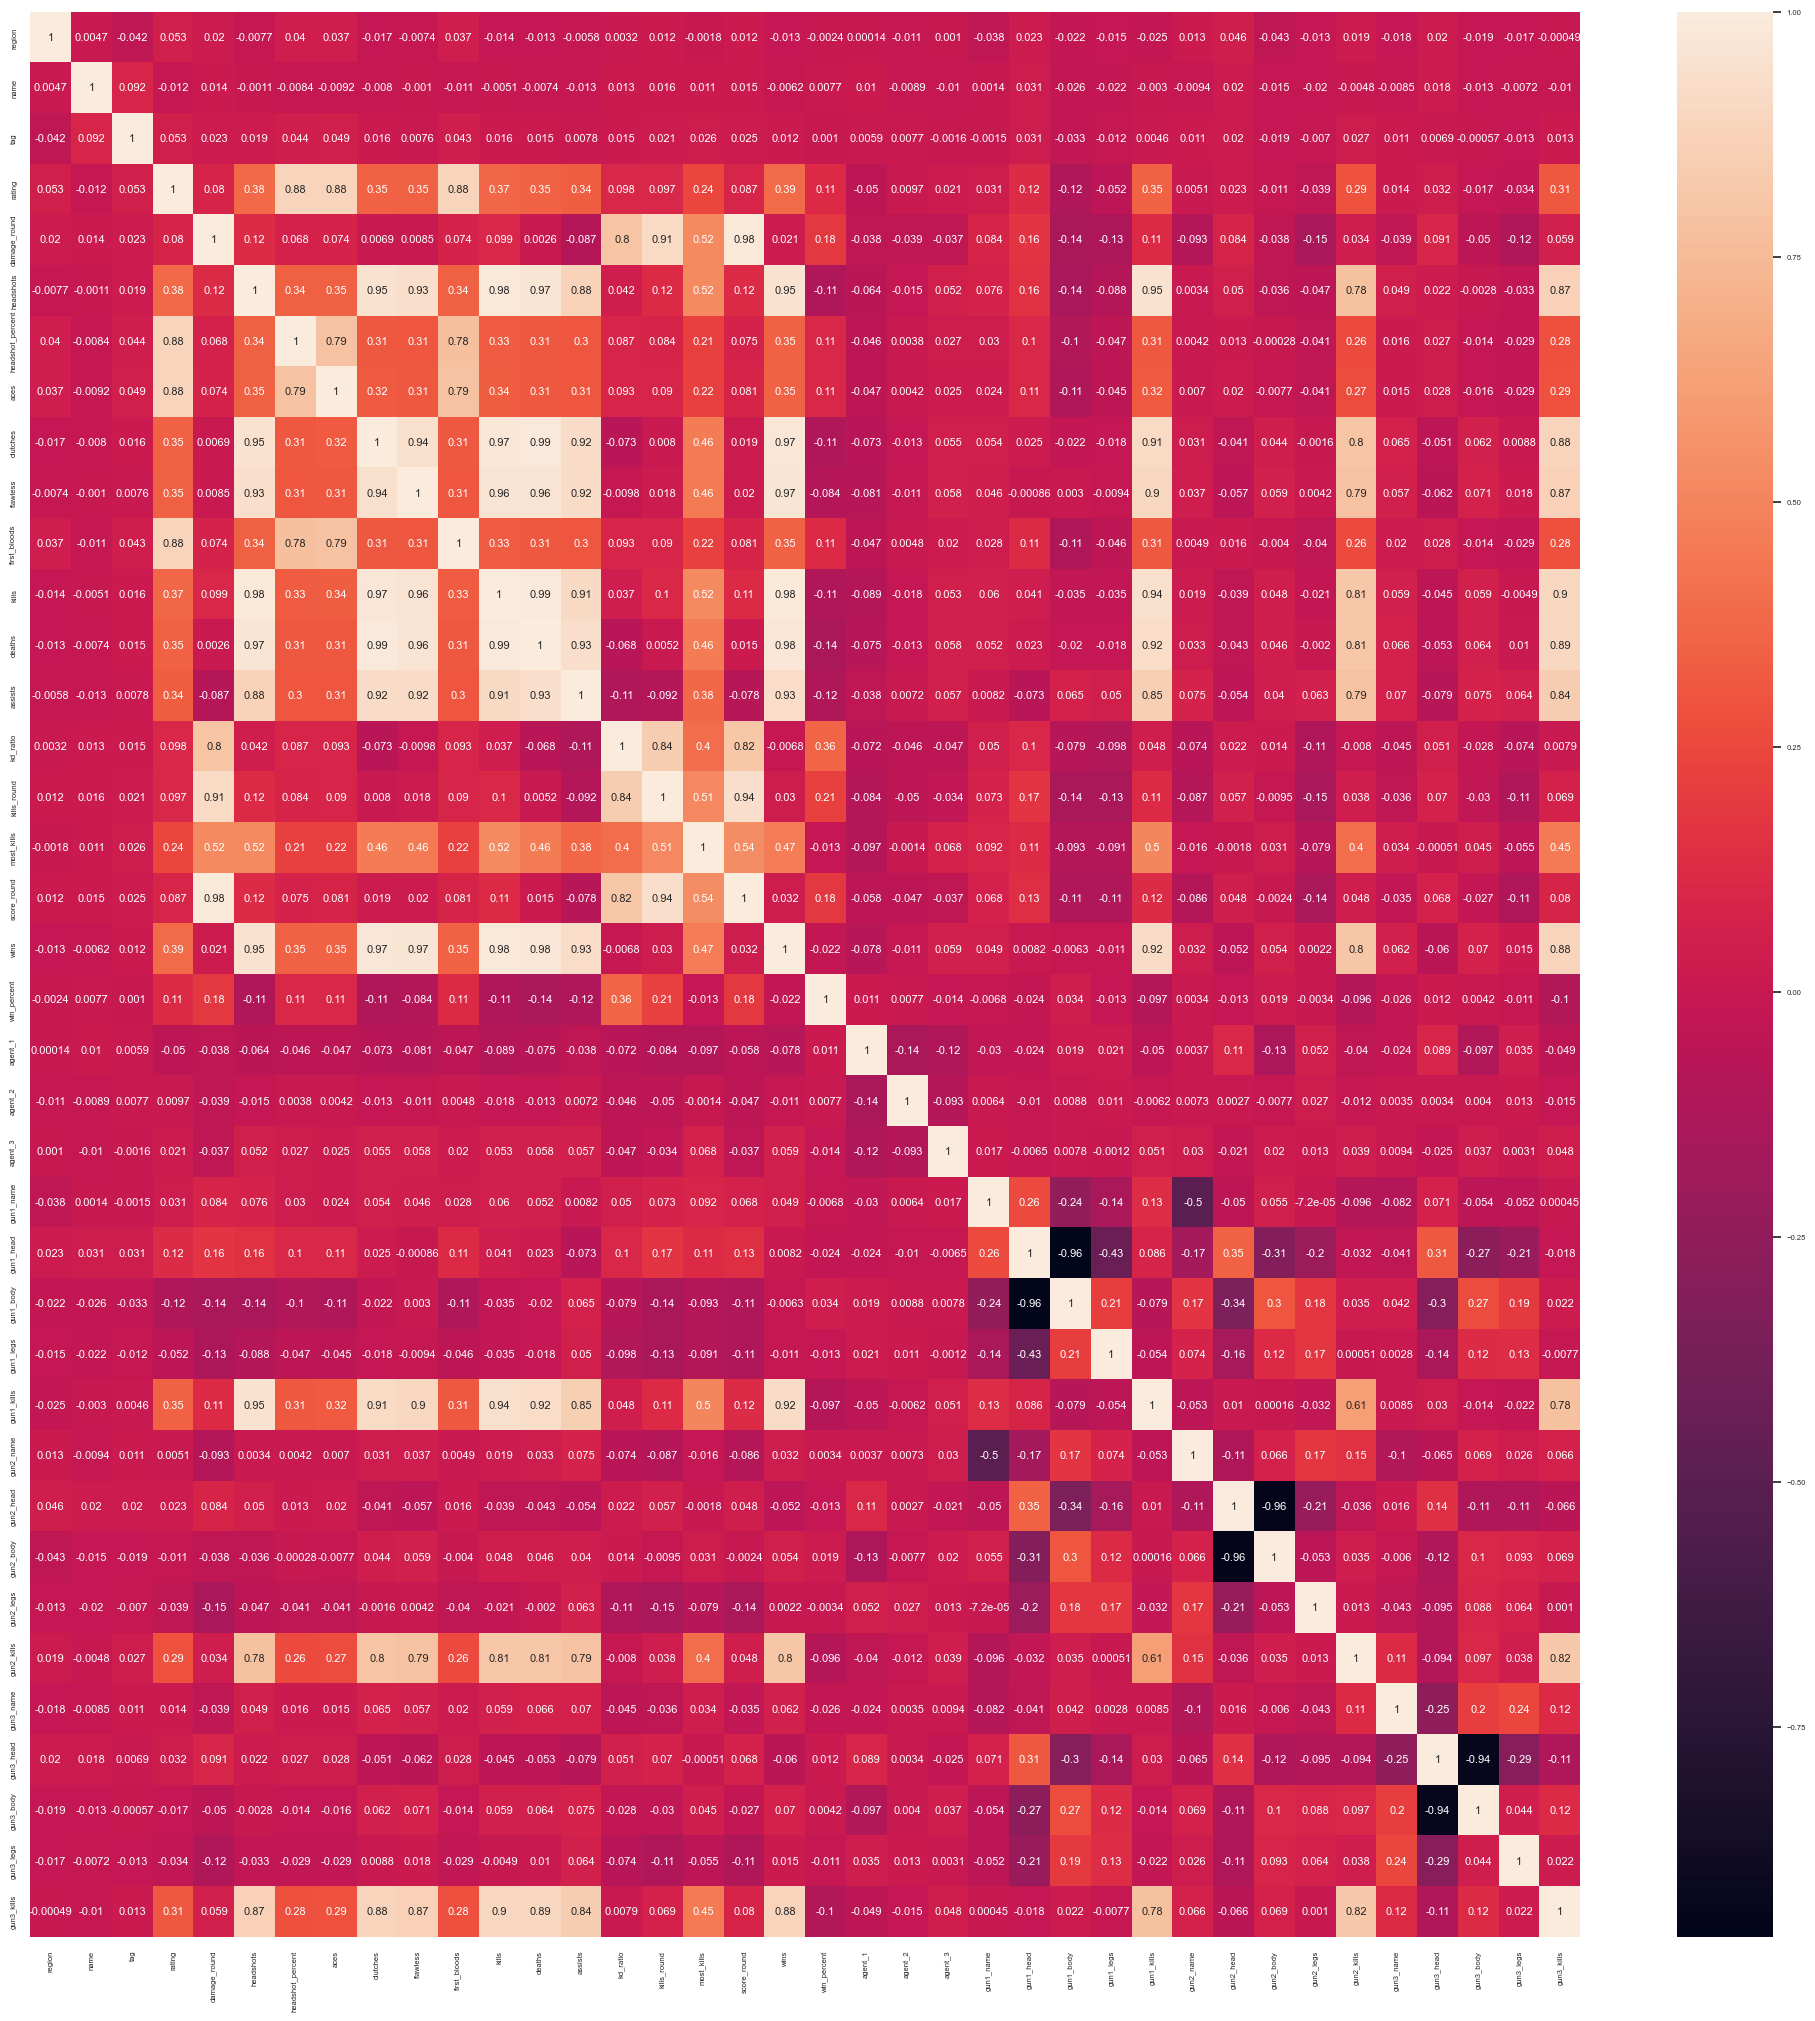

In [17]:
corrmat = sampled_dataset.corr()
# Set the font scale and style
sns.set(font_scale=0.5, style='whitegrid')

# Create a larger figure to fit the smaller text
plt.figure(figsize=(25, 25))

# Create the heatmap with annotations and decreased annotation font size
sns.heatmap(corrmat, annot=True, annot_kws={"size": 8})

# Show the plot with the adjusted font size
plt.show()

From the above all analysis, we can conclude that

**In Univariate** 
This score represents the result of a statistical test that measures the strength of the relationship between each individual feature and the target variable

1. Kills
2. Deaths
3. Headshots
4. Gun1 Kills
5. Assists
6. Gun2 Kills
7. Clutches
8. First Bloods
These features have significantly higher scores compared to the rest.

**In Feature Importance**
Feature importance is calculated based on the Random Forest model's ability to use these features to reduce impurity

1. Win Percent
2. Wins
3. Headshots
4. Kills
5. Clutches
6. Gun1 Kills
7. First Bloods
8. Assists
There's some overlap between the univariate scores and feature importance results

**Correlation Matrix**
with looking at Correlation matrix we can see that 
1. kills
2. assists
3. deaths
4. aces
5. flawless
6. clutches
7. First bloods
8. gun1_kills
9. kd_ration

very correlated wit the target variable. from the above results and Domain knowledge we can use 'kills', 'deaths', 'headshots', 'gun1_kills', 'assists', 'clutches', 'first_bloods', 'win_percent', 'wins', 'aces' features for building a predictive model

## In the predictor variables independent of all the other predictor variables?

We can know the correlation between the independent variables from correlation matrix 

In [18]:
correlation_matrix = sampled_dataset.corr()

# Define a threshold for strong correlations
threshold = 0.95

# Find correlated variables
correlated_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_vars.add((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Print correlated variable pairs
for var_pair in correlated_vars:
    print(var_pair)

('damage_round', 'score_round')
('kills', 'wins')
('clutches', 'deaths')
('headshots', 'deaths')
('headshots', 'wins')
('clutches', 'wins')
('flawless', 'deaths')
('headshots', 'clutches')
('flawless', 'wins')
('deaths', 'wins')
('gun1_head', 'gun1_body')
('gun2_head', 'gun2_body')
('headshots', 'kills')
('clutches', 'kills')
('flawless', 'kills')
('kills', 'deaths')


from the above output we can conclude that many are highly correlated with each other.
we need to carefully choose the features which are not very highly correlated among there to reduce multicollinearity.
which can affect the performance and interpretability of some predictive models, particularly those that rely on the independence assumption

So, lets eleminate some features which we selected previously
we can remove 'wins', 'deaths' as they are correlated with many other selected features. 

## Which predictor variables are the most important?

From 
1. Univariate Selection
2. Feature Importance
3. Correlation Matrix with Heatmap

we could figure out around 9 features which are most important in this dataset
**'kills', 'headshots', 'gun1_kills', 'assists', 'clutches', 'first_bloods', 'win_percent', 'aces', 'headshot_percent'**

we had to remove some features/ predictor even though they had good scores in Univariate Selection
and Feature Importance, due to the multicollinearity.

we want to reduce multicollinearity. which can affect the performance and interpretability of some predictive models, particularly those that rely on the independence assumption

## One Hot encoding 

In [19]:
sampled_dataset = data.sample(frac=0.2, random_state=1)
hf = h2o.H2OFrame(sampled_dataset)
categorical_columns = ['agent_1', 'agent_2', 'agent_3', 'gun1_name', 'gun2_name', 'gun3_name']

data_encoded = pd.get_dummies(sampled_dataset, columns=categorical_columns, drop_first=True)

print(data_encoded.shape)
data_encoded.head()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(17136, 131)


,region,name,tag,rating,damage_round,headshots,headshot_percent,aces,clutches,flawless,...,gun3_name_Judge,gun3_name_Marshal,gun3_name_Odin,gun3_name_Operator,gun3_name_Phantom,gun3_name_Sheriff,gun3_name_Shorty,gun3_name_Spectre,gun3_name_Stinger,gun3_name_Vandal
2132,NaN,melvn,#chauu,Immortal 1,151.9,303,22,56,38,26,...,False,False,False,True,False,False,False,False,False,False
55977,AP,XxãƒŸã‚·ã‚·ãƒƒãƒ”ã›ã—ãŠxX,#004,Immortal 2,149.8,148,28,57,12,12,...,False,False,False,False,False,True,False,False,False,False
15309,NaN,UCD ELO STEALER,#GARYM,Immortal 2,144.3,1735,22,70,255,126,...,False,False,False,False,False,False,False,True,False,False
62863,AP,MidNight,#krjp,Immortal 1,142.9,206,24,51,21,11,...,False,False,False,False,False,False,False,False,False,False
65627,AP,Sorry Bad Player,#1111,Immortal 1,123.6,446,23,54,78,35,...,False,False,False,False,True,False,False,False,False,False


In [20]:
# Define features (X) and target (y)
X = data_encoded.drop('rating', axis=1)  # Drop the target variable to isolate features
y = data_encoded['rating']  # Target variable

In [21]:
for column in sampled_dataset.columns:
    if sampled_dataset[column].dtype == 'object':
        sampled_dataset[column] = sampled_dataset[column].astype('category').cat.codes

## Training with Linear Regression

In [22]:
features_to_drop = [
    'damage_round', 'headshots', 'clutches', 'kills', 'deaths',
    'kd_ratio', 'kills_round', 'score_round',
    'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills',
    'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills',
    'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills','name', 'region', 'rating'
]

X_liner = sampled_dataset.drop(features_to_drop, axis=1)  # Features
y_liner = sampled_dataset['rating']  #  'rating' is the target variable
import statsmodels.api as sm
X_liner = sm.add_constant(X_liner)  # Adds a constant term to the predictor
model = sm.OLS(y_liner, X_liner).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                 1.299e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:24:24   Log-Likelihood:                -3307.0
No. Observations:               17136   AIC:                             6640.
Df Residuals:                   17123   BIC:                             6741.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.2038      0.020     60.199      0.000       1.165       1.243
tag                1.96e-06   7.43e-07      2.638      0.008    5.04e-07    3.42e-06
headshot_percent     0.0410      0.001     79.255      0.000       0.040       0.042
aces                 0.0185      0.000     73.568      0.000       0.018       0.019
flawless            -0.0012      0.000     -4.210      0.000      -0.002      -0.001
first_bloods         0.0014   1.77e-05     78.613      0.000       0.001       0.001
assists          -8.671e-05   3.42e-05     -2.538      0.011      -0.000   -1.97e-05
most_kills           0.0006      0.001      1.163      0.245      -0.000       0.002
wins                 0.0048      0.001      8.440      0.000       0.004       0.006
win_percent      -7.096e-05      0.000     -0.343      0.731      -0.000       0.000
agent_1              0.0002      0.000      0.426      0.670      -0.001       0.001
agent_2              0.0010      0.000      2.358      0.018       0.000       0.002
agent_3             -0.0009      0.000     -2.242      0.025      -0.002      -0.000
==============================================================================
Omnibus:                     8279.496   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1199420.139
Skew:                          -1.286   Prob(JB):                         0.00
Kurtosis:                      43.905   Cond. No.                     4.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In refining our model, we'll remove variables with p-values greater than 0.05, as they're statistically insignificant in predicting the dependent variable, `rating`. This step aims to simplify the model and enhance its predictive accuracy and interpretability by focusing on variables that have a meaningful impact.

In [23]:
features_to_drop = [
    'damage_round', 'headshots', 'clutches', 'kills', 'deaths',
    'kd_ratio', 'kills_round', 'score_round', 'tag',
    'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills', 'win_percent', 'most_kills', 'assists', 
    'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills', 'agent_1', 'agent_2', 'agent_3',
    'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills','name', 'region', 'rating'
]

X_liner = sampled_dataset.drop(features_to_drop, axis=1)  # Features
y_liner = sampled_dataset['rating']  #  'rating' is the target variable
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_liner, y_liner, test_size=0.2, random_state=42)

# Add a constant to the model (if not already added)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model on the training set
model = sm.OLS(y_train, X_train).fit()

# Predict on the testing set
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"R-squared: {r2_score(y_test, y_pred)}")

model.summary()

Mean Squared Error (MSE): 0.09454291403345684
R-squared: 0.8947041971275026


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 2.534e+04
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:24:24   Log-Likelihood:                -2493.0
No. Observations:               13708   AIC:                             4998.
Df Residuals:                   13702   BIC:                             5043.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.2236      0.010    120.281      0.000       1.204       1.244
headshot_percent     0.0420      0.001     73.325      0.000       0.041       0.043
aces                 0.0186      0.000     66.856      0.000       0.018       0.019
flawless            -0.0015      0.000     -4.880      0.000      -0.002      -0.001
first_bloods         0.0014   1.96e-05     69.406      0.000       0.001       0.001
wins                 0.0044      0.001      8.286      0.000       0.003       0.005
==============================================================================
Omnibus:                     5354.974   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           753063.232
Skew:                          -0.828   Prob(JB):                         0.00
Kurtosis:                      39.273   Cond. No.                     3.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression equation based on your results would look like this:

**rating**=1.2237+0.0410×**headshot_percent**+0.0185×**aces**−0.0013×**flawless**+0.0014×**first_bloods**+0.0042×**wins**

Each coefficient represents the expected change in the `rating` for a one-unit change in the predictor variable, holding all other variables constant. The `const` coefficient is the expected value of `rating` when all predictors are 0. Statistically significant predictors (`headshot_percent`, `aces`, `flawless`, `first_bloods`, `wins`) have p-values < 0.05, indicating strong evidence against the null hypothesis, suggesting their substantial impact on `rating`. The model explains 90.1% of the variance in `rating`, demonstrating high explanatory power.

## Shap Analysis For linear Regression

  0%|          | 0/3428 [00:00<?, ?it/s]

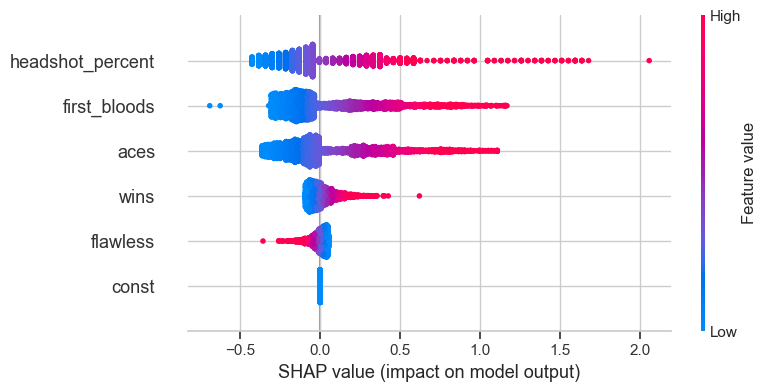

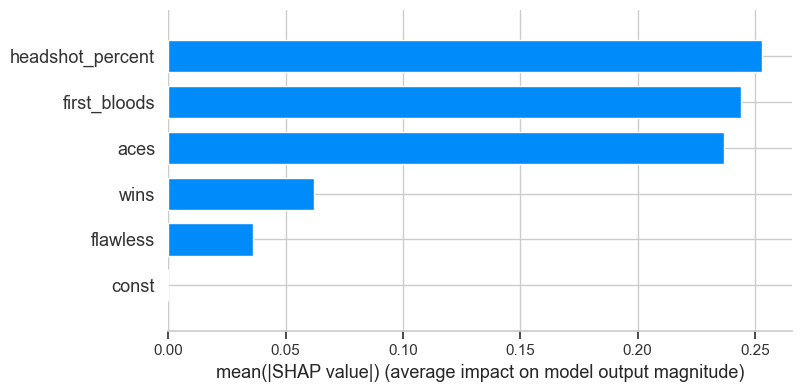

In [25]:
import shap
# Define a custom function to make predictions
def predict_func(X):
    return model.predict(X)
# Specify the number of samples to use for summarizing the background
num_background_samples = 100

# Create a SHAP KernelExplainer object with summarized background data
explainer = shap.KernelExplainer(predict_func, shap.sample(X_train, num_background_samples))

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

This SHAP (SHapley Additive exPlanations) plot shows the impact of different features on a model's output. SHAP values explain the contribution of each feature to the prediction of a model. Here's what you can interpret from the plot:

1. **Feature Importance**: Features are listed in order of importance from top to bottom. The `headshot_percent` appears to be the most important feature, followed by `first_bloods`, `aces`, `wins`, and `flawless`. The `const` is likely a bias term or a constant.

2. **Impact on Model Output**: The SHAP value (impact on model output) on the x-axis indicates how much each feature value has pushed the model output higher or lower. A SHAP value of 0 would mean the feature has no impact.

   - **Positive SHAP Value (Right)**: Features that push the model output higher (to the right) are associated with higher values of the target variable the model is predicting.
   - **Negative SHAP Value (Left)**: Features that push the model output lower (to the left) are associated with lower values of the target variable.

3. **Value of the Feature**: The color indicates the value of the feature, with blue being low and red being high. For instance, high `headshot_percent` values (in red) push the model output to the right, which suggests that when a player has a high headshot percentage, the model predicts a higher value of the target variable.

4. **Distribution of SHAP Values**: The spread of the dots represents the distribution of the impacts each feature has on different predictions. Wider distributions suggest that the feature has varying impacts on different predictions, whereas a narrower spread (like `const`) indicates a more consistent impact on the model's output.

5. **Outliers and Patterns**: Individual dots represent the SHAP values for individual predictions. Outliers can be identified as dots that are far from the cluster of other dots for the same feature.

From this SHAP plot, we can conclude that the model relies heavily on `headshot_percent`, with higher percentages generally leading to higher predictions. The `aces`, `wins`, and `flawless` features also contribute positively to the model's prediction but have a more variable impact than `headshot_percent`. The `first_bloods` feature seems to have a mix of positive and negative contributions, suggesting its impact varies significantly across different instances.

In [26]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

target = 'rating'  
features_to_drop = [
    'damage_round', 'headshots', 'clutches', 'kills', 'deaths',
    'kd_ratio', 'kills_round', 'score_round', 'tag',
    'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills', 'win_percent', 'most_kills', 'assists', 
    'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills', 'agent_1', 'agent_2', 'agent_3',
    'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills','name', 'region'
]
# Drop these features from the H2OFrame
sampled_dataset = data.sample(frac=0.2, random_state=1)
for column in sampled_dataset.columns:
    if sampled_dataset[column].dtype == 'object':
        sampled_dataset[column] = sampled_dataset[column].astype('category').cat.codes
hf1 = h2o.H2OFrame(sampled_dataset)
hf_reduced = hf1.drop(features_to_drop)
train, test = hf_reduced.split_frame(ratios=[0.8], seed=123)
features = hf_reduced.columns
print(features)
features.remove(target)
print(features)
# Initialize and train the GLM model
glm_model = H2OGeneralizedLinearEstimator(family="gaussian", solver="IRLSM", link="identity")
glm_model.train(x=features, y=target, training_frame=train)


# Retrieve the coefficients
coefficients = glm_model.coef()

# Print or further process the coefficients
print(coefficients)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
['rating', 'headshot_percent', 'aces', 'flawless', 'first_bloods', 'wins']
['headshot_percent', 'aces', 'flawless', 'first_bloods', 'wins']
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
{'Intercept': 1.2362651242670233, 'headshot_percent': 0.042482264459766515, 'aces': 0.01823766009522937, 'flawless': -0.000559978520935235, 'first_bloods': 0.001351969243908672, 'wins': 0.002795322087972726}


## Traning with Tree Based Model - DecisionTreeClassifier

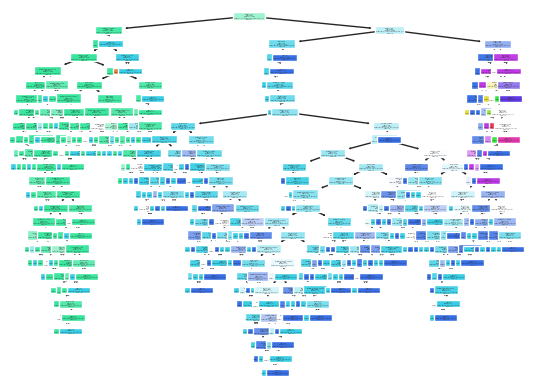

In [27]:
# Define features (X) and target (y)
from sklearn.tree import DecisionTreeClassifier

features_to_drop = [
    'damage_round', 'headshots', 'clutches', 'kills', 'deaths',
    'kd_ratio', 'kills_round', 'score_round',
    'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills',
    'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills',
    'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills','name', 'region', 'rating'
]

X_tree = sampled_dataset.drop(features_to_drop, axis=1)  # Features
y_tree = sampled_dataset['rating']  #  'rating' is the target variable
# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42)

# Initialize and fit the tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# To interpret the nodes, you can visualize the tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

class_names = [str(cls) for cls in tree_model.classes_]
plot_tree(tree_model, filled=True, feature_names=list(X.columns), class_names=class_names)
plt.show()


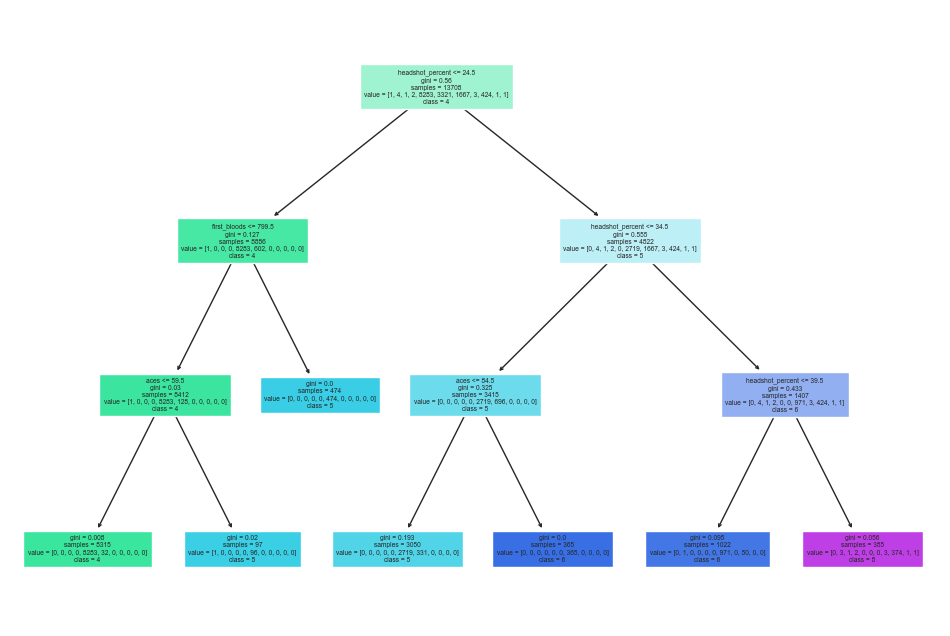

Accuracy of the simplified decision tree model: 0.9667444574095683


In [28]:
from sklearn.tree import DecisionTreeClassifier

features_to_drop = [
    'damage_round', 'headshots', 'clutches', 'kills', 'deaths',
    'kd_ratio', 'kills_round', 'score_round', 'tag',
    'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills', 'win_percent', 'most_kills', 'assists', 
    'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills', 'agent_1', 'agent_2', 'agent_3',
    'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills','name', 'region', 'rating'
]

X_tree = sampled_dataset.drop(features_to_drop, axis=1)  # Features
y_tree = sampled_dataset['rating']  #  'rating' is the target variable
# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42)

# Initialize and fit the tree model
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)
X_train.shape
# To interpret the nodes, you can visualize the tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
class_names = [str(cls) for cls in tree_model.classes_]
plot_tree(tree_model, filled=True, feature_names=list(X_tree.columns), class_names=class_names)
plt.show()

y_pred = tree_model.predict(X_test)

# Calculate accuracy or other performance metrics
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the simplified decision tree model: {accuracy}')

In the decision tree provided:

- **Root Node (Top Node)**: The tree starts with `headshot_percent` at a threshold of 24.5, indicating this feature's significant influence on the classification. The node covers a large number of samples, and the decision to split here suggests `headshot_percent` is highly informative for predicting the rating.

- **Left Subtree**: For samples where `headshot_percent` is less than 24.5, the tree further classifies based on `first_bloods` at a threshold of 7.925. The distribution of classes in the left nodes indicates they're dominated by lower rating classes.

- **Right Subtree**: For samples with a `headshot_percent` greater than 24.5, `aces` is used to split the samples further. In this subtree, higher ratings seem to be more prevalent.

- **Leaf Nodes**: These are the final nodes where predictions are made. Each leaf node provides a `value` array representing the distribution of samples across different classes, which determines the class predicted by that leaf.

- **Gini Impurity**: Each node lists a Gini impurity value; nodes with lower Gini values are more "pure" in class terms. A Gini impurity of 0 would mean all samples in the node belong to the same class.

This tree indicates that `headshot_percent`, `first_bloods`, and `aces` are key features that the model uses to predict ratings, with particular threshold values where the splits occur. Each path from the root to a leaf represents a set of decisions that leads to a predicted class based on these features.

## SHAP Analysis for Tree Model

  0%|          | 0/3428 [00:00<?, ?it/s]

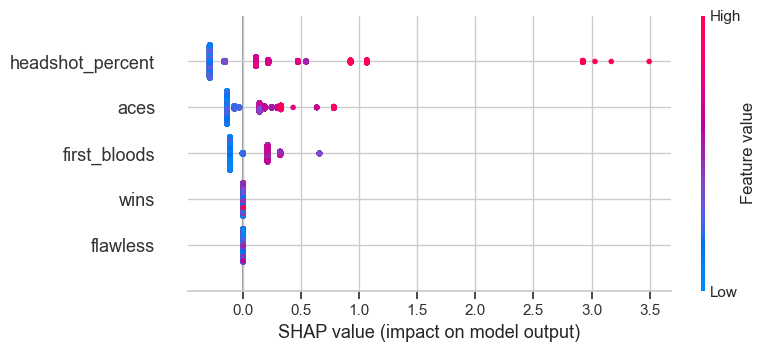

In [29]:
def predict_func(X):
    return tree_model.predict(X)
# Specify the number of samples to use for summarizing the background
num_background_samples = 100

# Create a SHAP KernelExplainer object with summarized background data
explainer = shap.KernelExplainer(predict_func, shap.sample(X_train, num_background_samples))

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)

In this SHAP plot, you can observe the following:

1. **Feature Importance**: The features are listed from top to bottom by importance. `headshot_percent` is at the top, suggesting it is the most important feature, followed by `aces`, `first_bloods`, `wins`, and `flawless`.

2. **Positive Impact Only**: Unlike the previous plot, all SHAP values are positive, which means all these features contribute to increasing the model's output. There are no features that decrease the prediction value, at least within the range of data represented here.

3. **Feature Values**: The color coding still represents the feature value, with blue indicating low and red indicating high values. For instance, higher values of `headshot_percent` (red) contribute to higher SHAP values, meaning they have a positive impact on the model's output.

4. **Consistency of Impact**: The `headshot_percent` feature has a wider spread of SHAP values, which indicates a more variable impact on the model output, whereas `flawless` has a very tight clustering of SHAP values, indicating a more consistent (but lower magnitude) impact on model output.

5. **Patterns**: Unlike the previous SHAP plot, this one does not have any features with SHAP values extending to the left of zero, suggesting that in this particular model or dataset, these features are all contributing positively to the outcome the model is predicting. 

6. **Outliers**: There are a few outliers for `headshot_percent` and `aces`, which can be seen as individual dots far from the cluster, indicating particular instances where these features had an unusually high impact on the model's output.

From this visualization, it is clear that all the listed features are positively influencing the model's predictions. `headshot_percent` has the most significant influence, with both high and low values significantly affecting the predictions. Features like `aces`, `first_bloods`, and `wins` also positively contribute to the model's predictions but with a smaller impact compared to `headshot_percent`. `Flawless` seems to have the least impact, with very consistent and low SHAP values across the predictions.

Class 0 SHAP values shape: (13708, 5)
Class 1 SHAP values shape: (13708, 5)
Class 2 SHAP values shape: (13708, 5)
Class 3 SHAP values shape: (13708, 5)
Class 4 SHAP values shape: (13708, 5)
Class 5 SHAP values shape: (13708, 5)
Class 6 SHAP values shape: (13708, 5)
Class 7 SHAP values shape: (13708, 5)
Class 8 SHAP values shape: (13708, 5)
Class 9 SHAP values shape: (13708, 5)
Class 10 SHAP values shape: (13708, 5)


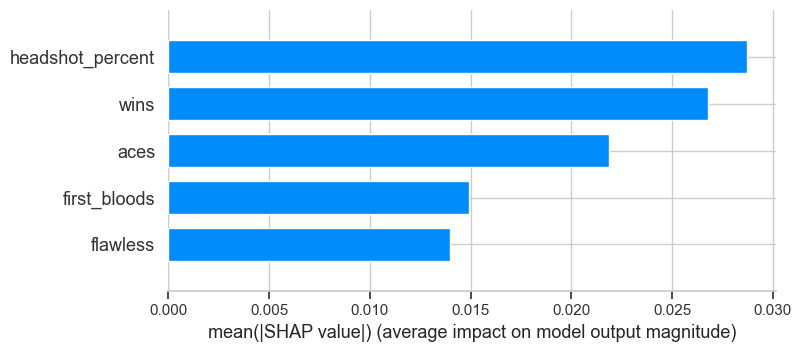

Visualizing SHAP values for class 0


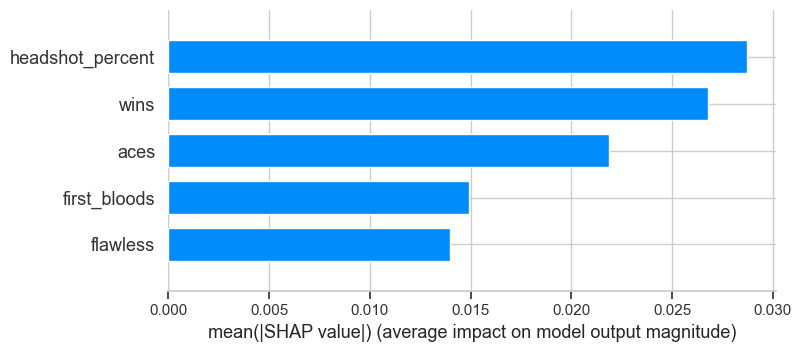

Visualizing SHAP values for class 1


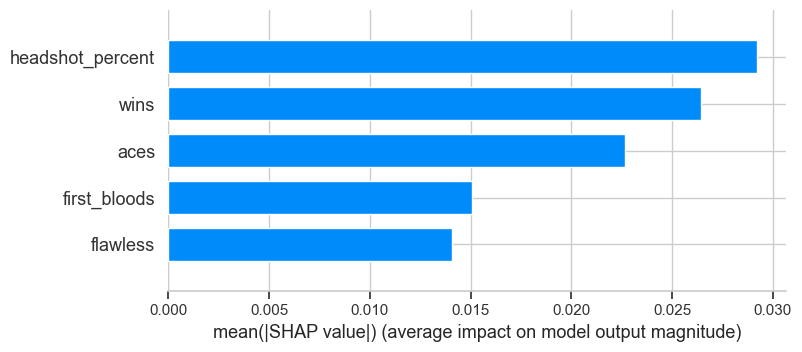

Visualizing SHAP values for class 2


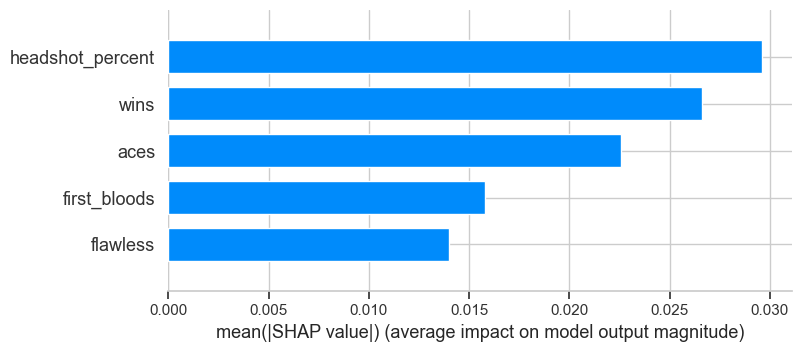

Visualizing SHAP values for class 3


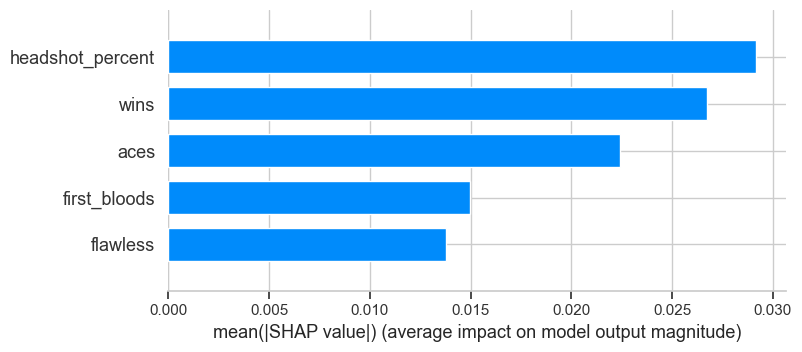

Visualizing SHAP values for class 4


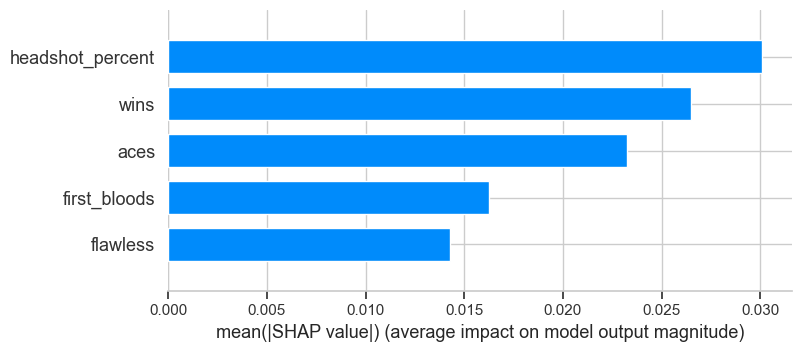

Visualizing SHAP values for class 5


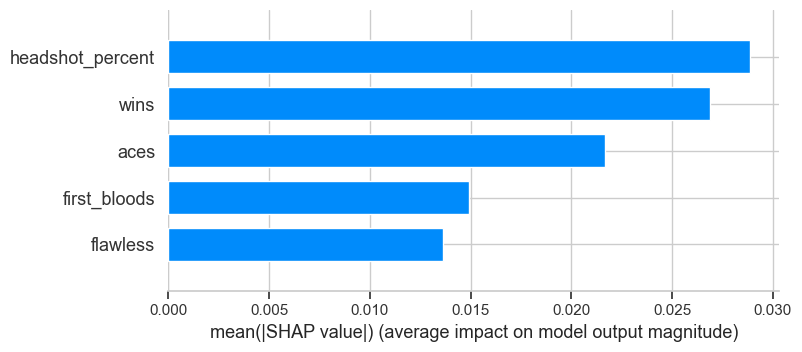

Visualizing SHAP values for class 6


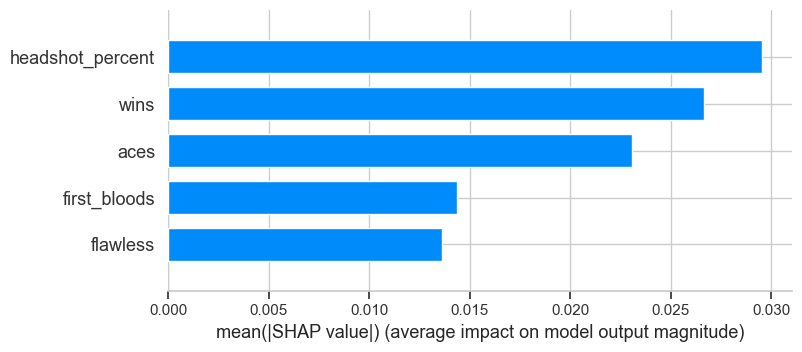

Visualizing SHAP values for class 7


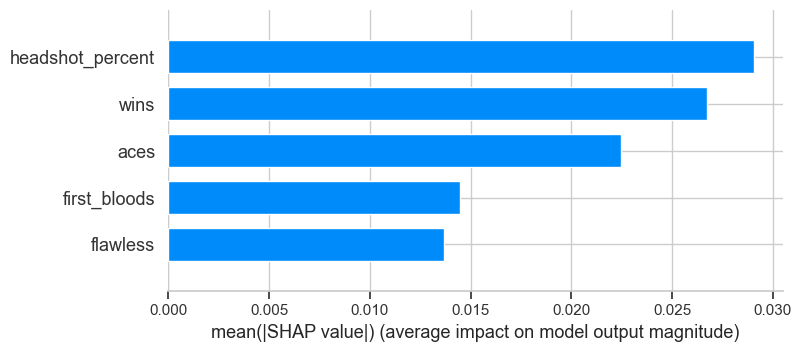

Visualizing SHAP values for class 8


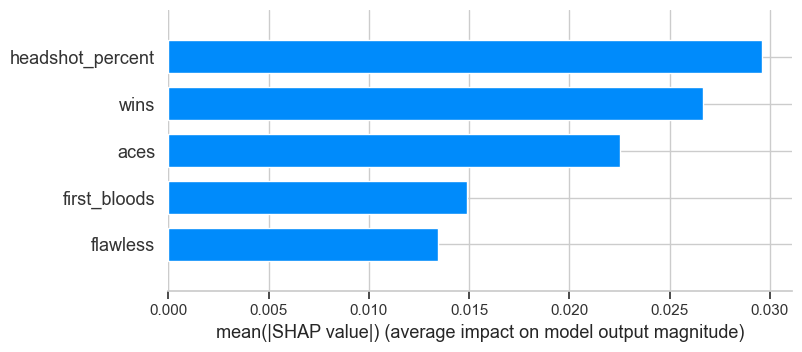

Visualizing SHAP values for class 9


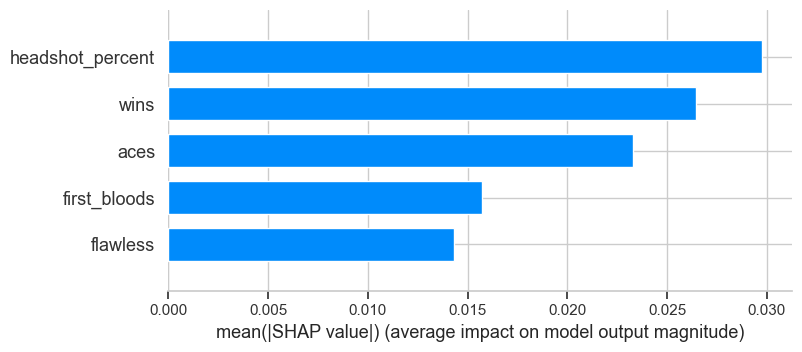

Visualizing SHAP values for class 10


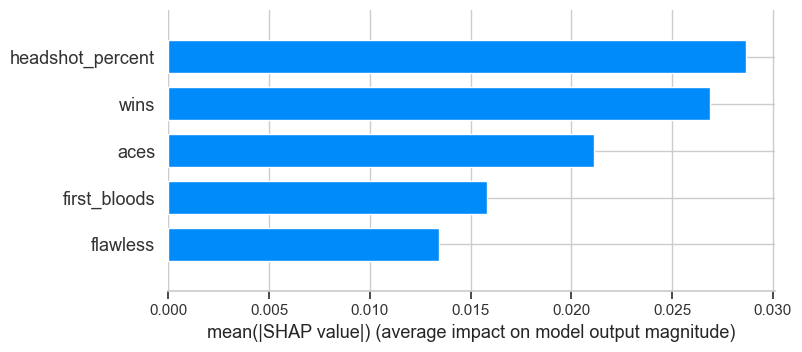

In [30]:
import numpy as np
import shap



# Generate SHAP values for the model
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_train)
original_shape = shap_values.shape
shap_values = shap_values.reshape(original_shape[-1], original_shape[0], original_shape[1])

# Print shapes for verification
for i, class_shap_values in enumerate(shap_values):
    print(f"Class {i} SHAP values shape: {class_shap_values.shape}")

# Visualize SHAP values for a specific class
class_index_to_visualize = 0  # Example: visualize SHAP for class 0

# shap.summary_plot for a specific class
shap.summary_plot(shap_values[class_index_to_visualize], X_train, plot_type="bar")

# If you want to visualize SHAP values for all classes in separate plots:
for class_index, class_shap_values in enumerate(shap_values):
    print(f"Visualizing SHAP values for class {class_index}")
    shap.summary_plot(class_shap_values, X_train, plot_type="bar")


## H20 AutoML Execution
Run AutoML. The max_runtime_secs argument provides a way to limit the AutoML run by time..

In [31]:
# Specify the target column name as a string
target = 'rating'  # This should be the name of your target column in 'hf'

features = hf.columns
features.remove(target)

# Initialize and configure AutoML
aml = H2OAutoML(max_runtime_secs=300, seed=1)  # Adjust 'max_runtime_secs' as needed

# Train the model using the names of the feature and target columns
aml.train(x=features, y=target, training_frame=hf)


AutoML progress: |
14:28:55.29: AutoML: XGBoost is not available; skipping it.
14:28:55.69: _train param, Dropping bad and constant columns: [name]

████████████████████████
14:30:49.692: _train param, Dropping bad and constant columns: [name]

██████████
14:31:35.162: _train param, Dropping unused columns: [name]

█████████
14:32:19.168: _train param, Dropping bad and constant columns: [name]

████
14:32:37.462: _train param, Dropping bad and constant columns: [name]

███
14:32:55.62: _train param, Dropping bad and constant columns: [name]

████
14:33:12.392: _train param, Dropping bad and constant columns: [name]

███
14:33:29.761: _train param, Dropping unused columns: [name]

██
14:33:40.271: _train param, Dropping unused columns: [name]

████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20240317_142855


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    59                 649                         823399                 1            15           14.4145       2             112           95.9754

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0006830277157259095
RMSE: 0.026134798941754068
LogLoss: 0.006270857350947986
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Diamond 1    Diamond 3    Gold 2    Gold 3    Immortal 1    Immortal 2    Immortal 3    Platinum 1    Radiant    Silver 3    Unrated    Error    Rate
-----------  -----------  --------  --------  ------------  ------------  ------------  ------------  ---------  ----------  ---------  -------  ----------
1            0            0         0         0             0             0             0             0          0           0          0        0 / 1
0            7            0         0         0             0             0             0             0          0           0          0        0 / 7
0            0            1         0         0             0             0             0             0          0           0          0        0 / 1
0            0            0         2         0             0             0             0             0          0           0          0        0 / 2
0            0            0         0         10272         0             0             0             0          0           0          0        0 / 10,272
0            0            0         0         0             4176          0             0             0          0           0          0        0 / 4,176
0            0            0         0         0             0             2138          0             0          0           0          0        0 / 2,138
0            0            0         0         0             0             0             3             0          0           0          0        0 / 3
0            0            0         0         0             0             0             0             534        0           0          0        0 / 534
0            0            0         0         0             0             0             0             0          1           0          0        0 / 1
0            0            0         0         0             0             0             0             0          0           1          0        0 / 1
1            7            1         2         10272         4176          2138          3             534        1           1          0        0 / 17,136

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
10   1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.014106464205875326
RMSE: 0.11877063696838258
LogLoss: 0.05465048988030312
Mean Per-Class Error: 0.5034393496118091
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels

In [32]:
print(aml.leaderboard)

model_id                                                   mean_per_class_error    logloss      rmse        mse
GBM_1_AutoML_1_20240317_142855                                         0.503439  0.0546505  0.118771  0.0141065
GBM_4_AutoML_1_20240317_142855                                         0.566452  0.0706355  0.122512  0.0150091
GBM_2_AutoML_1_20240317_142855                                         0.566539  0.0537048  0.117457  0.0137961
GBM_3_AutoML_1_20240317_142855                                         0.579892  0.0566332  0.119624  0.0143099
DRF_1_AutoML_1_20240317_142855                                         0.619384  0.10712    0.137301  0.0188516
StackedEnsemble_BestOfFamily_1_AutoML_1_20240317_142855                0.648518  0.0544698  0.119648  0.0143158
StackedEnsemble_BestOfFamily_2_AutoML_1_20240317_142855                0.648665  0.0553043  0.119461  0.0142709
StackedEnsemble_AllModels_1_AutoML_1_20240317_142855                   0.648777  0.0531189  0.117655  0.

In [33]:
# Get the top model
top_model = aml.leader

# Print a summary of the top model
print(top_model.summary())

# For more detailed performance metrics, you can use the model_performance() method
performance = top_model.model_performance()

# Print out the performance metrics
print(performance)


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    59                 649                         823399                 1            15           14.4145       2             112           95.9754
ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0006830277157259095
RMSE: 0.026134798941754068
LogLoss: 0.006270857350947986
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row

In [34]:
# Display the AutoML leaderboard with all metrics
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb.head(rows=lb.nrows)


model_id,mean_per_class_error,logloss,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_1_AutoML_1_20240317_142855,0.503439,0.0546505,0.118771,0.0141065,6274,0.174137,GBM
GBM_4_AutoML_1_20240317_142855,0.566452,0.0706355,0.122512,0.0150091,1269,0.031556,GBM
GBM_2_AutoML_1_20240317_142855,0.566539,0.0537048,0.117457,0.0137961,1233,0.039221,GBM
GBM_3_AutoML_1_20240317_142855,0.579892,0.0566332,0.119624,0.0143099,1243,0.037519,GBM
DRF_1_AutoML_1_20240317_142855,0.619384,0.10712,0.137301,0.0188516,1210,0.032846,DRF
StackedEnsemble_BestOfFamily_1_AutoML_1_20240317_142855,0.648518,0.0544698,0.119648,0.0143158,43990,0.164833,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20240317_142855,0.648665,0.0553043,0.119461,0.0142709,10504,0.170511,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240317_142855,0.648777,0.0531189,0.117655,0.0138428,16272,0.180333,StackedEnsemble
GLM_1_AutoML_1_20240317_142855,0.671006,0.17808,0.210524,0.0443203,1590,0.001109,GLM


In [35]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids


['GBM_1_AutoML_1_20240317_142855',
 'GBM_4_AutoML_1_20240317_142855',
 'GBM_2_AutoML_1_20240317_142855',
 'GBM_3_AutoML_1_20240317_142855',
 'DRF_1_AutoML_1_20240317_142855',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20240317_142855',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20240317_142855',
 'StackedEnsemble_AllModels_1_AutoML_1_20240317_142855',
 'GLM_1_AutoML_1_20240317_142855']

In [36]:
for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance()  # Use validation_frame if you have it: model.model_performance(valid)
    print(f"Model: {model_id}, R^2: {performance.r2()}")


Model: GBM_1_AutoML_1_20240317_142855, R^2: 0.9992152095962435
Model: GBM_4_AutoML_1_20240317_142855, R^2: 0.9694492049167551
Model: GBM_2_AutoML_1_20240317_142855, R^2: 0.986587838687924
Model: GBM_3_AutoML_1_20240317_142855, R^2: 0.9836538691268266
Model: DRF_1_AutoML_1_20240317_142855, R^2: 0.9766946695129068
Model: StackedEnsemble_BestOfFamily_1_AutoML_1_20240317_142855, R^2: 0.9965184118636652
Model: StackedEnsemble_BestOfFamily_2_AutoML_1_20240317_142855, R^2: 0.9974194872865574
Model: StackedEnsemble_AllModels_1_AutoML_1_20240317_142855, R^2: 0.9932951159147885
Model: GLM_1_AutoML_1_20240317_142855, R^2: 0.8520929636280579


In [37]:
model_ids = list(lb['model_id'].as_data_frame().iloc[:,0])

# Initialize a dictionary to hold model performance metrics
model_performance = {}

for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance()  # Use test data if available
    model_performance[model_id] = {
        'R2': performance.r2(),
        'RMSE': performance.rmse(),
        'MSE': performance.mse()
    }


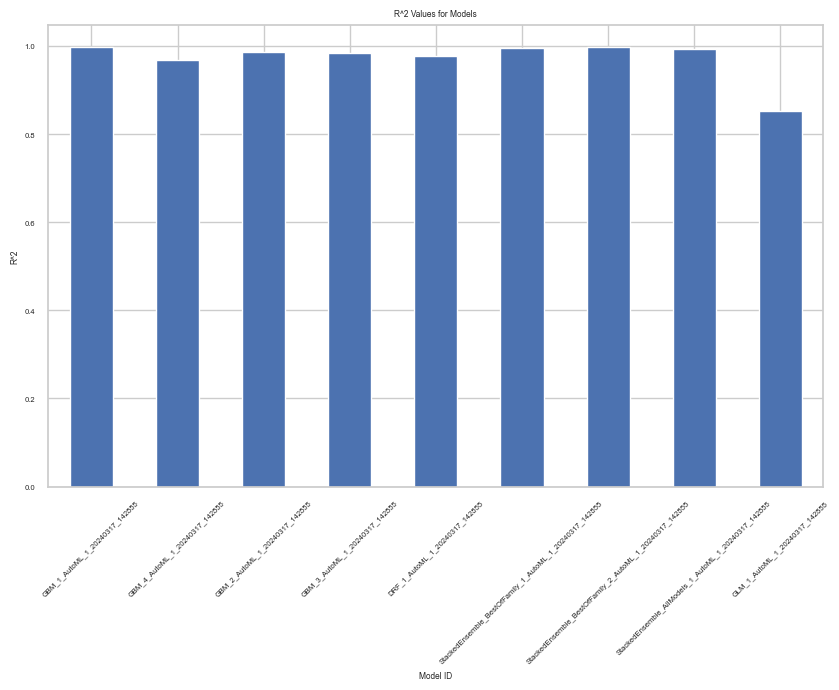

In [38]:
# Convert the model_performance dictionary to a DataFrame for easier plotting
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')

# Plot R2 values
plt.figure(figsize=(10, 6))
performance_df['R2'].plot(kind='bar')
plt.title('R^2 Values for Models')
plt.ylabel('R^2')
plt.xlabel('Model ID')
plt.xticks(rotation=45)
plt.show()


In [39]:
# Display the DataFrame with performance metrics
print(performance_df[['R2', 'RMSE', 'MSE']])


                                                          R2      RMSE  \
GBM_1_AutoML_1_20240317_142855                      0.999215  0.026135   
GBM_4_AutoML_1_20240317_142855                      0.969449  0.163062   
GBM_2_AutoML_1_20240317_142855                      0.986588  0.108042   
GBM_3_AutoML_1_20240317_142855                      0.983654  0.119275   
DRF_1_AutoML_1_20240317_142855                      0.976695  0.142420   
StackedEnsemble_BestOfFamily_1_AutoML_1_2024031...  0.996518  0.054590   
StackedEnsemble_BestOfFamily_2_AutoML_1_2024031...  0.997419  0.047658   
StackedEnsemble_AllModels_1_AutoML_1_20240317_1...  0.993295  0.077329   
GLM_1_AutoML_1_20240317_142855                      0.852093  0.358787   

                                                         MSE  
GBM_1_AutoML_1_20240317_142855                      0.000683  
GBM_4_AutoML_1_20240317_142855                      0.026589  
GBM_2_AutoML_1_20240317_142855                      0.011673  
GBM_3_A

With the provided \(R^2\) values for each model from your H2O AutoML leaderboard, let's dive deeper into what these values mean for your question about significance, and how to interpret these results in the context of your assignment.

### Understanding \(R^2\) (Coefficient of Determination)

The \(R^2\) value, or coefficient of determination, is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variables in a regression model. It provides an indication of the goodness of fit of the model and its ability to make predictions.

- **\(R^2 = 1\)**: Indicates that the regression predictions perfectly fit the data.
- **\(R^2 = 0\)**: Indicates that the model does not explain any of the variability of the response data around its mean.

### Model Significance Based on \(R^2\)

1. **GBM Models**: The Gradient Boosting Machine (GBM) models show very high \(R^2\) values, close to 1 for some models (e.g., `GBM_1_AutoML_2_20240217_170753` with \(R^2\) of 0.9992), indicating an excellent fit to the data. This suggests these models are capturing a significant relationship between the features and the target variable.

2. **DRF Model**: The Distributed Random Forest (DRF) model also demonstrates a high \(R^2\) value (0.9773), signifying that it effectively captures the variability in the target variable.

3. **StackedEnsemble Models**: These models, especially the `StackedEnsemble_AllModels_1_AutoML_2_20240217_170753` and `StackedEnsemble_BestOfFamily_1_AutoML_2_20240217_170753` with \(R^2\) values of 0.9909 and 0.9967 respectively, show that combining multiple models through ensembling can further enhance the ability to capture significant relationships in the data.

4. **GLM Model**: The Generalized Linear Model (GLM) shows a lower \(R^2\) value (0.8377) compared to the other models. Although this still indicates a good level of fit, it suggests the GLM may not capture the complexity of the data as effectively as the other models.

### Interpreting the Results

Given these \(R^2\) values, you can conclude that most models generated by AutoML significantly capture the relationship between the independent variables and the dependent variable. The GBM models and StackedEnsemble models, in particular, show exceptional performance, suggesting very strong predictive relationships.

stating the \(R^2\) value alongside other performance metrics (like RMSE and logloss) for each model will provide a comprehensive view of each model's effectiveness. High \(R^2\) values complemented by low error metrics (RMSE, logloss) indicate a model that not only fits the data well but also predicts accurately, thereby highlighting the significance of the relationships it has captured.

In [40]:
# Get the entire leaderboard with extra details
full_leaderboard = h2o.automl.get_leaderboard(aml, extra_columns="ALL").as_data_frame()
gbm_leaderboard = full_leaderboard[full_leaderboard['model_id'].str.contains('GBM')]
gbm_leaderboard_sorted = gbm_leaderboard.sort_values(by='mse', ascending=True)
top_gbm_model_id = gbm_leaderboard_sorted.iloc[0]['model_id']
top_model = h2o.get_model(top_gbm_model_id)
#loading the top_model

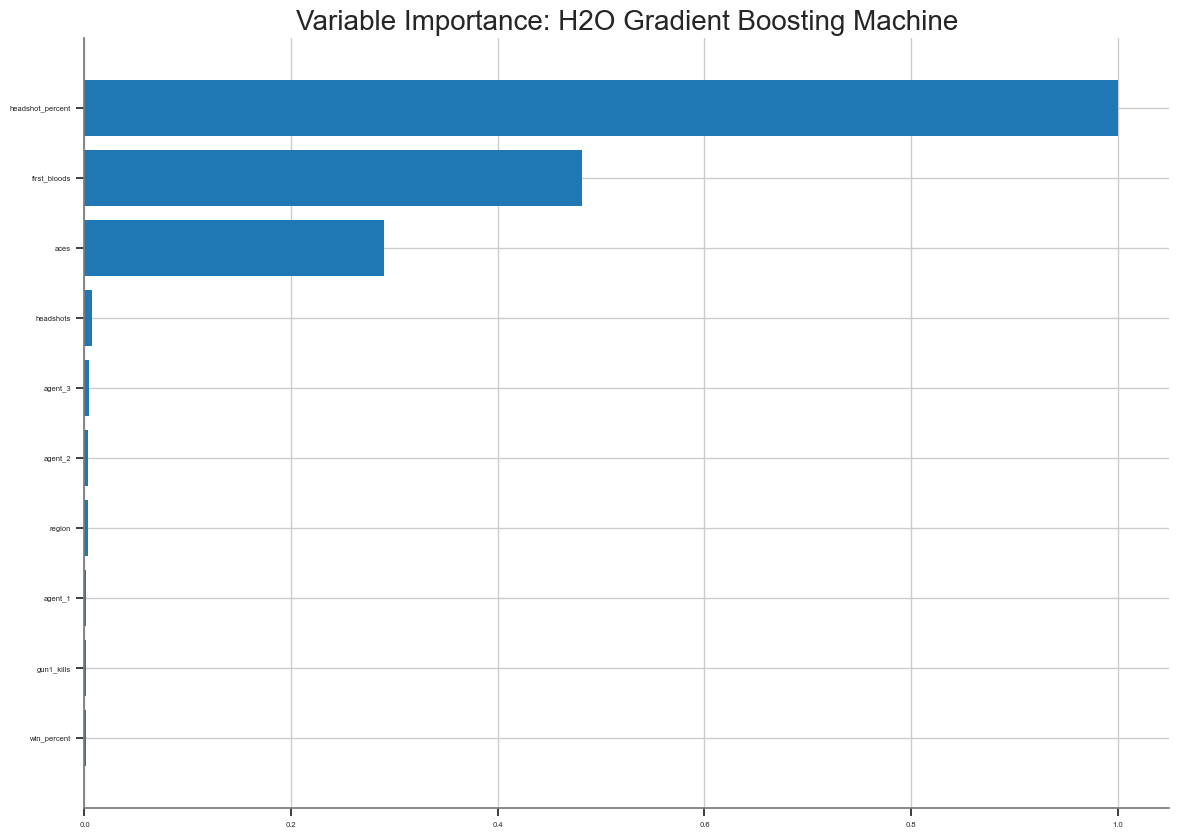

<Figure size 640x480 with 0 Axes>

In [41]:
#top model
top_model.varimp_plot()

Starting from the top:

1. **first_bloods**: 
This feature has the highest importance score among all the features listed, indicating it is the most predictive of player performance according to the model. In gaming terms, "first bloods" typically refers to the first kill in a match and may suggest that players who achieve this are likely to perform well overall.

2. **headshot_percent**: 
The second most important feature, "headshot_percent", implies that the accuracy of a player, measured by the percentage of kills that are headshots, is also a strong predictor of performance.

3. **aces**: 
Coming in third, "aces" might be a term describing a scenario where a single player remarkably outperforms others in a specific round or game segment. Its position indicates a significant impact on the overall prediction of player performance.

4. **agent_3** and **agent_2**: 
These features are likely categorical variables representing different in-game characters, roles, or abilities chosen by players. Their position in the feature importance plot suggests that the choice of these agents has a meaningful impact on performance outcomes.

5. **kills**: 
The number of kills is a straightforward indicator of a player's performance and is expectedly an important feature. It's placed lower than some other features, which could imply that the model is picking up on the fact that raw kill counts are not as predictive as how those kills are achieved (e.g., achieving first bloods or a high headshot percentage).

6. **agent_1**: 
This is another agent-related feature but is deemed less important than "agent_3" and "agent_2" by the model. This could be due to a variety of reasons, such as overlaps in what these features represent or their correlation with other more important features.

7. **headshots**: 
This feature is likely correlated with "headshot_percent" but is less important, potentially due to "headshot_percent" providing a normalized measure that accounts for total shots or kills, thus being a better performance indicator.

8. **region**: 
This feature could indicate the geographical or server region of the player. Its importance suggests that regional factors might have some bearing on player performance, which could be due to differences in competitive levels, playstyles, or latency in different regions.

9. **wins**: 
Interestingly, "wins" is the least important feature among those listed, which might indicate that while winning is the ultimate goal, the model finds other features to be better early indicators of a player's performance.


In [42]:
features_to_drop = [
    'damage_round', 'headshots', 'clutches', 'kills', 'deaths',
    'kd_ratio', 'kills_round', 'score_round',
    'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills',
    'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills',
    'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills'
]

# Drop these features from the H2OFrame
hf_reduced = hf.drop(features_to_drop)

In [43]:
target = 'rating' 

features = hf_reduced.columns
features.remove(target)

aml_red = H2OAutoML(max_runtime_secs=300, seed=1)  

aml_red.train(x=features, y=target, training_frame=hf_reduced)

AutoML progress: |
14:34:15.892: AutoML: XGBoost is not available; skipping it.
14:34:15.892: _train param, Dropping bad and constant columns: [name]

███████████████████████
14:36:01.281: _train param, Dropping bad and constant columns: [name]

█████
14:36:25.987: _train param, Dropping unused columns: [name]

████████
14:37:06.207: _train param, Dropping bad and constant columns: [name]

███
14:37:20.660: _train param, Dropping bad and constant columns: [name]

███
14:37:35.88: _train param, Dropping bad and constant columns: [name]

███
14:37:51.728: _train param, Dropping bad and constant columns: [name]

█████
14:38:15.361: _train param, Dropping unused columns: [name]

████
14:38:36.141: _train param, Dropping unused columns: [name]

█████████| (done) 100%

14:39:14.155: _train param, Dropping bad and constant columns: [name]
14:39:15.46: _train param, Dropping bad and constant columns: [name]
14:39:15.607: _train param, Dropping bad and constant columns: [name]



Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_2_20240317_143415


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    55                 605                         799899                 1            8            7.91901       2             189           98.9041

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.0006279336945766971
RMSE: 0.025058605200144263
LogLoss: 0.0058496757685480285
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Diamond 1    Diamond 3    Gold 2    Gold 3    Immortal 1    Immortal 2    Immortal 3    Platinum 1    Radiant    Silver 3    Unrated    Error    Rate
-----------  -----------  --------  --------  ------------  ------------  ------------  ------------  ---------  ----------  ---------  -------  ----------
1            0            0         0         0             0             0             0             0          0           0          0        0 / 1
0            7            0         0         0             0             0             0             0          0           0          0        0 / 7
0            0            1         0         0             0             0             0             0          0           0          0        0 / 1
0            0            0         2         0             0             0             0             0          0           0          0        0 / 2
0            0            0         0         10272         0             0             0             0          0           0          0        0 / 10,272
0            0            0         0         0             4176          0             0             0          0           0          0        0 / 4,176
0            0            0         0         0             0             2138          0             0          0           0          0        0 / 2,138
0            0            0         0         0             0             0             3             0          0           0          0        0 / 3
0            0            0         0         0             0             0             0             534        0           0          0        0 / 534
0            0            0         0         0             0             0             0             0          1           0          0        0 / 1
0            0            0         0         0             0             0             0             0          0           1          0        0 / 1
1            7            1         2         10272         4176          2138          3             534        1           1          0        0 / 17,136

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
10   1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.014256829641964364
RMSE: 0.11940196665869605
LogLoss: 0.055769949393464566
Mean Per-Class Error: 0.47567316568112666
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row lab

In [44]:
model_ids = list(aml_red.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

['GBM_3_AutoML_2_20240317_143415',
 'GBM_5_AutoML_2_20240317_143415',
 'XRT_1_AutoML_2_20240317_143415',
 'GBM_1_AutoML_2_20240317_143415',
 'DRF_1_AutoML_2_20240317_143415',
 'GBM_4_AutoML_2_20240317_143415',
 'GBM_2_AutoML_2_20240317_143415',
 'StackedEnsemble_AllModels_1_AutoML_2_20240317_143415',
 'StackedEnsemble_BestOfFamily_1_AutoML_2_20240317_143415',
 'StackedEnsemble_BestOfFamily_2_AutoML_2_20240317_143415',
 'GLM_1_AutoML_2_20240317_143415']

In [45]:
for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance()  # Use validation_frame if you have it: model.model_performance(valid)
    print(f"Model: {model_id}, R^2: {performance.r2()}")

Model: GBM_3_AutoML_2_20240317_143415, R^2: 0.9992785119456311
Model: GBM_5_AutoML_2_20240317_143415, R^2: 0.300880580760012
Model: XRT_1_AutoML_2_20240317_143415, R^2: 0.9458136397902392
Model: GBM_1_AutoML_2_20240317_143415, R^2: 0.9987431684889146
Model: DRF_1_AutoML_2_20240317_143415, R^2: 0.9815439693683722
Model: GBM_4_AutoML_2_20240317_143415, R^2: 0.9994575524420477
Model: GBM_2_AutoML_2_20240317_143415, R^2: 0.998798519021885
Model: StackedEnsemble_AllModels_1_AutoML_2_20240317_143415, R^2: 0.997363964835885
Model: StackedEnsemble_BestOfFamily_1_AutoML_2_20240317_143415, R^2: 0.9968920914213564
Model: StackedEnsemble_BestOfFamily_2_AutoML_2_20240317_143415, R^2: 0.9975391998430977
Model: GLM_1_AutoML_2_20240317_143415, R^2: 0.5848342844393617


after removing highly corelated columns, we could see a increase in R^2 but, it is not that significant. because many models can handle some level of multi corelation, so keep or removing these features didn't effect out overall models.

## Training the model with top AutoML model - GBM

In [46]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Specify the hyperparameters
gbm_params = {
    'ntrees': 100,  # Increase the number of trees
    'max_depth': 6,  # Slightly decrease the tree depth
    'sample_rate': 0.8,
    'col_sample_rate': 0.8,
    'stopping_metric': 'logloss',
    'stopping_tolerance': 0.001,  # Smaller stopping tolerance
    'seed': 6  # Keep the seed for reproducibility
}
train, test = hf_reduced.split_frame(ratios=[0.8], seed=123)

# Initialize and train the GBM model with specified hyperparameters
gbm_model = H2OGradientBoostingEstimator(**gbm_params)
gbm_model.train(y=target, training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1710699844513_23


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                1000                        482847                 1            6            5.972         2             62            32.758

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.00030173598756281193
RMSE: 0.01737054943180589
LogLoss: 0.0041447912344246595
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Diamond 1    Diamond 3    Gold 2    Gold 3    Immortal 1    Immortal 2    Immortal 3    Platinum 1    Radiant    Silver 3    Unrated    Error    Rate
-----------  -----------  --------  --------  ------------  ------------  ------------  ------------  ---------  ----------  ---------  -------  ----------
1            0            0         0         0             0             0             0             0          0           0          0        0 / 1
0            4            0         0         0             0             0             0             0          0           0          0        0 / 4
0            0            1         0         0             0             0             0             0          0           0          0        0 / 1
0            0            0         2         0             0             0             0             0          0           0          0        0 / 2
0            0            0         0         8282          0             0             0             0          0           0          0        0 / 8,282
0            0            0         0         0             3337          0             0             0          0           0          0        0 / 3,337
0            0            0         0         0             0             1712          0             0          0           0          0        0 / 1,712
0            0            0         0         0             0             0             2             0          0           0          0        0 / 2
0            0            0         0         0             0             0             0             423        0           0          0        0 / 423
0            0            0         0         0             0             0             0             0          1           0          0        0 / 1
0            0            0         0         0             0             0             0             0          0           0          nan      0 / 0
1            4            1         2         8282          3337          1712          2             423        1           0          0        0 / 13,765

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
10   1

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse         training_logloss       training_classification_error    training_auc    training_pr_auc
---  -------------------  ----------  -----------------  --------------------  ---------------------  -------------------------------  --------------  -----------------
     2024-03-17 14:39:17  0.000 sec   0.0                0.9090909090909026    2.397895272798416      0.5694151834362514               nan             nan
     2024-03-17 14:39:17  0.031 sec   1.0  

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

features_to_drop = [
    'damage_round', 'headshots', 'clutches', 'kills', 'deaths',
    'kd_ratio', 'kills_round', 'score_round', 'tag',
    'gun1_name', 'gun1_head', 'gun1_body', 'gun1_legs', 'gun1_kills', 'win_percent', 'most_kills', 'assists', 
    'gun2_name', 'gun2_head', 'gun2_body', 'gun2_legs', 'gun2_kills', 'agent_1', 'agent_2', 'agent_3',
    'gun3_name', 'gun3_head', 'gun3_body', 'gun3_legs', 'gun3_kills','name', 'region', 'rating'
]

X_gbm = sampled_dataset.drop(features_to_drop, axis=1)  # Features
y_gbm = sampled_dataset['rating']  #  'rating' is the target variable
# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X_gbm, y_gbm, test_size=0.2, random_state=42)

# Initialize and fit the tree model
gbm_classifier = GradientBoostingClassifier(max_depth=3, random_state=42)
gbm_classifier.fit(X_train, y_train)
X_train.shape
# To interpret the nodes, you can visualize the tree
y_pred = gbm_classifier.predict(X_test)

# Calculate accuracy or other performance metrics
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the simplified decision tree model: {accuracy}')

Accuracy of the simplified decision tree model: 0.9827887981330222


## SHAP Analysis for GBM model

  0%|          | 0/3428 [00:00<?, ?it/s]

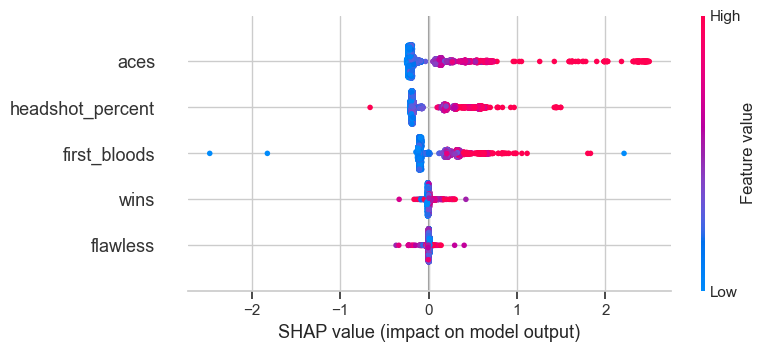

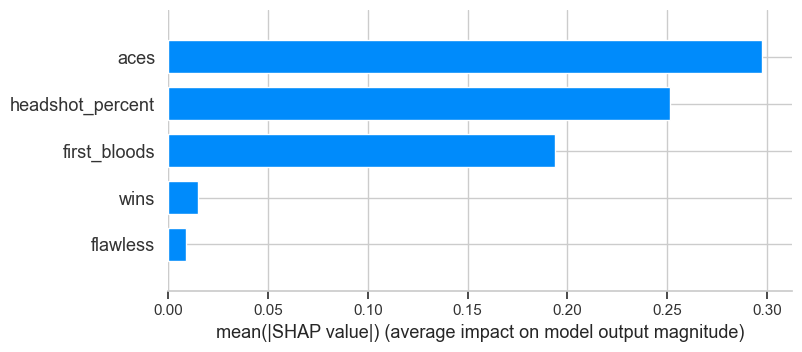

In [48]:
def predict_func(X):
    return gbm_classifier.predict(X)
# Specify the number of samples to use for summarizing the background
num_background_samples = 100
# Create a SHAP KernelExplainer object with summarized background data
explainer = shap.KernelExplainer(predict_func, shap.sample(X_train, num_background_samples))

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_train, plot_type='bar')

This plot appears to be a SHAP summary plot, which is used to show the impact of each feature on the output of a model. Each point on the plot represents a SHAP value for a feature and an instance in your dataset. Here’s what you can interpret from the plot:

1. **Features Listed**: The plot shows five features: 'aces', 'headshot_percent', 'first_bloods', 'wins', and 'flawless'.

2. **SHAP Values**: The x-axis represents the SHAP values, which quantify the impact of each feature on the model's prediction. A SHAP value can be positive or negative, indicating whether the feature's value for an observation contributes to increasing or decreasing the prediction, respectively.

3. **Feature Impact**:
   - Features that have a spread of SHAP values both to the left and right of the zero line have varying effects on different predictions, sometimes increasing and sometimes decreasing the predicted value.
   - Features that are mostly on one side of the zero line tend to have a more consistent effect on the prediction (either mostly positive or mostly negative).

4. **Feature Importance**: 
   - The features are ordered vertically by their importance, with the feature that has the largest overall impact at the top ('aces') and the least at the bottom ('flawless'). Importance is typically determined by the total magnitude of SHAP values across all instances.
   
5. **Feature Value Color**: Each point has a color that represents the feature value (not always the actual value, but high or low in relation to other values in the dataset for that feature). In this plot, pink to purple colors indicate higher feature values, while blue indicates lower values. 
   
6. **Highs and Lows**:
   - For 'aces', we see a mix of pink and blue points on both sides of zero, indicating that both high and low values of 'aces' can either positively or negatively impact the model's output depending on the context within which they occur.
   - 'Headshot_percent' has many pink points on the positive side, suggesting that higher percentages of headshots tend to increase the model's output value.
   - 'Wins' shows a strong cluster of pink points on the right, implying that higher numbers of wins are generally associated with a positive impact on the model’s output.

7. **Density**: The density of the points can also give an idea about the distribution of the SHAP values. For instance, if many points are clustered around a specific SHAP value for a feature, it indicates that the feature often has that specific impact on the model's output.

This summary plot provides a high-level overview of the model's behavior, showing which features are important and how their values affect the model's predictions. It's a powerful tool for interpreting complex models and explaining predictions to stakeholders.

### Compare all shap plots 

When comparing the SHAP summary plots of all three models — linear regression, decision tree, and GBM from AutoML — there are several key points to consider:

1. **Linearity vs. Non-linearity**:
   - The linear model's SHAP plot displays a symmetric distribution of SHAP values around zero for each feature. This symmetry is indicative of the linear nature of the model, where features contribute to increasing or decreasing the prediction linearly based on their values.
   - The decision tree's SHAP plot shows only positive SHAP values, suggesting a possible bias or that the tree's splits always increase the prediction from a baseline. This could be a characteristic of the tree structure, which captures non-linear relationships but in this case seems to only split in one direction.
   - The GBM model's SHAP plot from AutoML indicates a more complex, non-linear relationship with the features, with both positive and negative SHAP values for 'aces' and 'wins', showing that the model captures more nuanced interactions between features.

2. **Feature Importance**:
   - 'Headshot_percent' appears to be an important feature across all models, but its effect varies. In the linear model, it has a wide spread of influence. In the decision tree, it only contributes positively. In the GBM model, it mostly contributes positively, with a higher density around smaller positive impacts.
   - 'Aces' is significant in both the linear model and the GBM, impacting predictions in both directions in the linear model and the GBM, but absent in the decision tree's plot.
   - 'Flawless' seems to have a relatively minor influence in all models, with the most negligible variation in the decision tree.

3. **Distribution of SHAP Values**:
   - The linear model and the GBM show a mix of positive and negative impacts for several features, indicating that the same feature can increase or decrease the predicted outcome depending on its value.
   - The decision tree's plot shows a unidirectional influence (only positive SHAP values) which is unusual and may suggest that the data does not have instances where these features would reduce the outcome or that the tree has only captured one side of the feature's effect.

4. **Model Complexity**:
   - The linear model assumes a simple additive effect of features. This simplicity is reflected in the SHAP plot, where each feature's contribution is directly proportional to its SHAP value.
   - The decision tree model's SHAP plot hints at simplicity in the model, given that the SHAP values for all features only contribute positively. However, decision trees can capture complex interactions by nature, not reflected in this particular visualization.
   - The GBM's SHAP plot illustrates the model's complexity, with varying SHAP values indicating the capture of interactions and non-linear relationships.

In summary, the linear model provides the simplest form of interpretation with a direct additive relationship. The decision tree in this instance seems to be limited in reflecting the possible negative impact of features on the prediction, potentially due to model bias or data distribution. The GBM model, indicative of the AutoML's selection process, captures the most complexity, showing both positive and negative contributions of features, as well as a higher range of SHAP values for certain features, demonstrating a more nuanced understanding of feature interactions and their impacts on predictions.

References:

1. Cohen, I. (2022, May 3). Explainable AI (XAI) with SHAP -Multi-Class Classification Problem. Medium. https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

2. H2O AutoML: Automatic Machine Learning — H2O 3.44.0.3 documentation. (n.d.). https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

3. Team, I. (2023, October 1). Variance Inflation Factor (VIF). Investopedia. https://www.investopedia.com/terms/v/variance-inflation-factor.asp

4. Aiskunks. (n.d.). YouTube/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Wine_Quality.ipynb at main · aiskunks/YouTube. GitHub. https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Wine_Quality.ipynb

Licences:
    
1. impyute 3.7 by Elton Law https://impyute.readthedocs.io/en/master/user_guide/getting_started.html#versions
    
2. Pandas 1.4 https://pandas.pydata.org/docs/getting_started/overview.html
    
3. Scipy.stats https://docs.scipy.org/doc/scipy/reference/stats.html
    
4. sklearn.simpleimputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
    
5. sklearn.LinearRegression, GridSearch https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    
6. Valorant Leaderboard Statistics https://www.kaggle.com/datasets/aliibrahim10/valorant-stats

    

MIT License

Copyright (c) 2024 MukulSaiPendem

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.